In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:
# Hyperparameters
batch_size = 64
epochs = 50
lr = 0.00005
latent_dim = 100

In [3]:
# Data loader
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate networks


Files already downloaded and verified


In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Output: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Output: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Output: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Output: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)


In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 256 x 8 x 8 
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            # Output:512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, x):
        return self.model(x)



In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)
optimizer_G = optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = optim.RMSprop(D.parameters(), lr=lr)



In [7]:
clamp_lower = -0.01
clamp_upper = 0.01
n_critic = 5

In [8]:
import os
import torchvision.utils as vutils
from pathlib import Path

In [9]:
output_dir = Path("Images/wganimages")
output_dir.mkdir(parents=True, exist_ok=True)
real_images_dir = output_dir / "real"
real_images_dir.mkdir(parents=True, exist_ok=True)
fake_images_dir = output_dir / "fake"
fake_images_dir.mkdir(parents=True, exist_ok=True)


In [10]:
#Training
best_images = []
best_scores = []

for epoch in range(epochs):
    for i, (batch_data, _) in enumerate(train_loader):
        real_data = batch_data.to(device)
        real_data_size = real_data.size(0)
        
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            
            #Real data
            real_data_prediction = D(real_data)
            real_data_loss = -torch.mean(real_data_prediction)
            
            #Fake data
            noise = torch.randn(real_data_size, latent_dim, 1, 1, device = device)
            fake_data = G(noise)
            fake_data_prediction = D(fake_data.detach())
            fake_data_loss = -torch.mean(fake_data_prediction)
            
            #Update Discriminator 
            dis_loss = real_data_loss - fake_data_loss
            dis_loss.backward()
            optimizer_D.step()
            
            # Clip discriminator weights
            for p in D.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
            
            # Train Generator
        optimizer_G.zero_grad()
            
        #Generate fake data
        noise = torch.randn(real_data_size, latent_dim, 1, 1, device = device)
        fake_data = G(noise)
        fake_data_prediction = D(fake_data)
        # Update generator
        gen_loss = -torch.mean(fake_data_prediction)
        gen_loss.backward()
        optimizer_G.step()
        

    #print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {dis_loss.item():.4f} | G_loss: {gen_loss.item():.4f}")

    # Generate and save images after each epoch
    with torch.no_grad():
        fixed_noise = torch.randn(1000, latent_dim, 1, 1, device=device)
        generated_images = G(fixed_noise).detach().cpu()
        img_scores = D(generated_images.to(device)).detach().cpu().numpy()

    # Update the best images list
    for img, score in zip(generated_images, img_scores):
        if len(best_images) < 10:
            best_images.append(img)
            best_scores.append(score)
        else:
            min_index = best_scores.index(min(best_scores))
            if score > best_scores[min_index]:
                best_images[min_index] = img
                best_scores[min_index] = score 
    if epoch == 49:
        #for idx, img in enumerate(real_data.cpu()):
           # vutils.save_image(img, real_images_dir/f"w_real_image{epoch}_{idx}.png", normalize=True)
        for idx, img in enumerate(generated_images.cpu()):
            vutils.save_image(img, fake_images_dir/f"w_fake_image{epoch}_{idx}.png", normalize=True)
    
    print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {dis_loss.item():.4f} | G_loss: {gen_loss.item():.4f}")



Epoch [1/50] | D_loss: -1.5697 | G_loss: 0.7866
Epoch [2/50] | D_loss: -1.5951 | G_loss: 0.7984
Epoch [3/50] | D_loss: -1.5246 | G_loss: 0.7686
Epoch [4/50] | D_loss: -1.5237 | G_loss: 0.7641
Epoch [5/50] | D_loss: -1.5592 | G_loss: 0.7752
Epoch [6/50] | D_loss: -1.4823 | G_loss: 0.7320
Epoch [7/50] | D_loss: -0.0885 | G_loss: 0.7481
Epoch [8/50] | D_loss: -1.5046 | G_loss: 0.7598
Epoch [9/50] | D_loss: -1.4991 | G_loss: 0.7508
Epoch [10/50] | D_loss: -1.3393 | G_loss: 0.6739
Epoch [11/50] | D_loss: -0.6725 | G_loss: 0.0376
Epoch [12/50] | D_loss: -1.4757 | G_loss: 0.7324
Epoch [13/50] | D_loss: -1.4842 | G_loss: 0.7398
Epoch [14/50] | D_loss: -1.3175 | G_loss: 0.6332
Epoch [15/50] | D_loss: -0.9932 | G_loss: 0.7001
Epoch [16/50] | D_loss: -1.4797 | G_loss: 0.7397
Epoch [17/50] | D_loss: -1.3079 | G_loss: 0.6867
Epoch [18/50] | D_loss: -0.5392 | G_loss: 0.5102
Epoch [19/50] | D_loss: -1.0477 | G_loss: 0.3302
Epoch [20/50] | D_loss: -0.6918 | G_loss: 0.5952
Epoch [21/50] | D_loss: -1.51

In [11]:

import torchvision.utils as vutils
import matplotlib.pyplot as plt


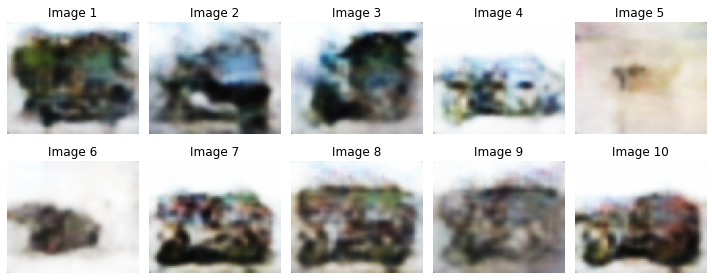

In [12]:
# Plot the 10 best generated images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, img in enumerate(best_images):
    ax = axes[i // 5, i % 5]
    img_np = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
    ax.imshow(img_np, aspect="auto")
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [14]:
num_images = 0

for images, _ in train_loader:
    if num_images >= 1000:
        break

    for idx, img in enumerate(images):
        if num_images >= 1000:
            break
        vutils.save_image(img, real_images_dir / f"real_image_{num_images}.png", normalize=True)
        num_images += 1

In [15]:
import os
from PIL import Image
from torchmetrics.image.fid import FrechetInceptionDistance

real_image_dir = "/home/jingjiw/Images/Real"
fake_image_dir = "/home/jingjiw/Images/wganimages/fake"

preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

def read_and_preprocess_image(img_path):
    img = Image.open(img_path)
    preprocessed_img = preprocess(img)
    return (preprocessed_img * 255).byte()


real_image_files = [f'real_image_{i}.png' for i in range(1000)]
fake_image_files = [f'w_fake_image49_{i}.png' for i in range(1000)]

real_images = torch.stack([read_and_preprocess_image(os.path.join(real_image_dir, file)) for file in real_image_files])
fake_images = torch.stack([read_and_preprocess_image(os.path.join(fake_image_dir, file)) for file in fake_image_files])

fid = FrechetInceptionDistance()

fid.update(real_images, real=True)
fid.update(fake_images, real=False)

fid_score = fid.compute()
print("FID score:", fid_score)

FID score: tensor(119.4209)
